In [1]:
import scanpy as sc

from gene_trajectory.add_gene_bin_score import add_gene_bin_score
from gene_trajectory.coarse_grain import select_top_genes, coarse_grain_adata
from gene_trajectory.extract_gene_trajectory import get_gene_embedding, extract_gene_trajectory
from gene_trajectory.get_graph_distance import get_graph_distance
from gene_trajectory.gene_distance_shared import cal_ot_mat
from gene_trajectory.run_dm import run_dm
from gene_trajectory.plot.gene_trajectory_plots import plot_gene_trajectory_3d, plot_gene_trajectory_umap
from gene_trajectory.util.download_file import download_file_if_missing

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

# Gene Trajectory Python tutorial: Mouse dermal #

The standard preprocessing can be done by employing the scanpy Python package which includes: 
library normalization; finding variable features; scaling; generating PCA embedding (and UMAP embedding for visualization).

First, we download the data from [figshare](https://figshare.com/articles/dataset/Processed_AnnData_objects_for_GeneTrajectory_inference_Gene_Trajectory_Inference_for_Single-cell_Data_by_Optimal_Transport_Metrics_/25539547), where a copy of the data needed for the tutorial is saved. 

In [3]:
download_file_if_missing('tutorial_data/mouse_dermal_scanpy_obj.h5ad', 
    url='https://figshare.com/ndownloader/files/45448612',  
    md5_hash='1af2efd46499d9e1e45e83d6f2de891a',
    create_target_folder_if_missing=True)

Once the file has been downloaded and saved to `tutorial_data/mouse_dermal_scanpy_obj.h5ad`, we load the preprocessed Scanpy Anndata object where we will perform the gene trajectory inference.

In [4]:
adata = sc.read_h5ad('tutorial_data/mouse_dermal_scanpy_obj.h5ad')

The data contains a precomputed UMAP and contains the following annotations
- orig.ident: the original sample
- cell_type: the cell type of each cell

Next, we visualize the annotations on the UMAP using the plotting tools available in Scanpy

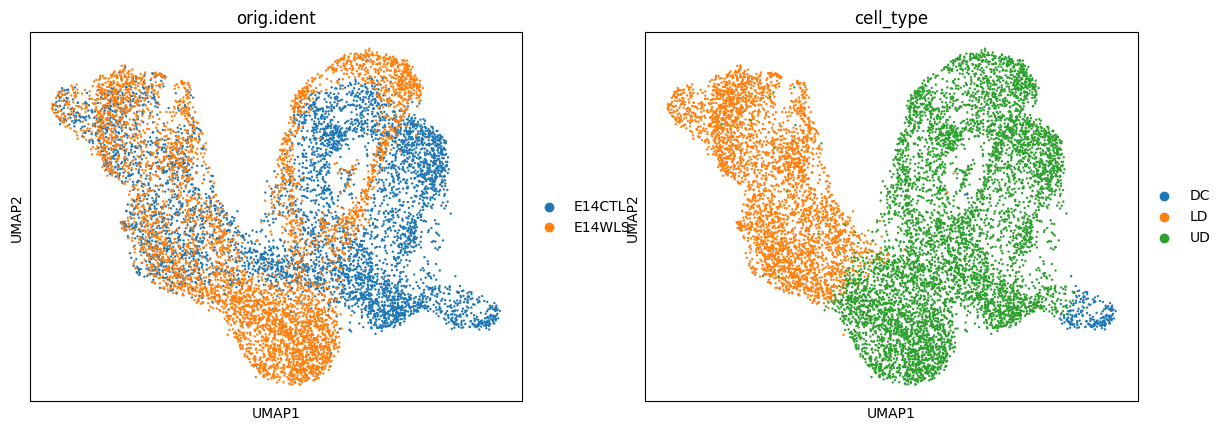

In [5]:
sc.pl.umap(adata, color=["orig.ident", "cell_type"])

## Gene trajectory analysis ##

First, we construct the cell-cell kNN graph and calculate cell-cell graph distances. 
The the diffusion map calculated in the first step will be stored in `adata.obsm['X_dm']`, which will be later used to compute the `cell_graph_dist` matrix. 

In [6]:
run_dm(adata)
cell_graph_dist = get_graph_distance(adata, k=10)

We then narrow down the gene list for gene-gene distance computation by focusing on the top 2000 variable genes expressed by 1% - 50% of cells. The `select_top_genes` method requires a layer with count data. In this dataset, the counts are available in `adata.raw` and a copy is added as the 'counts' layer before running `select_top_genes`.
Next, the number of cells is reduced by coarse-graining.  

In [7]:
if 'counts' not in adata.layers:
    adata.layers['counts'] = adata.raw.X.copy()
genes = select_top_genes(adata, layer='counts')
gene_expression_updated, graph_dist_updated = coarse_grain_adata(adata, graph_dist=cell_graph_dist, features=genes, dims=10)


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


The gene-gene Wasserstein distance can then be computed. Note that the computation is computationally expensive and will take around 30-50 minutes on this dataset. 

In [8]:
gene_dist_mat = cal_ot_mat(gene_expr=gene_expression_updated, ot_cost=graph_dist_updated, show_progress_bar=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 692076/692076 [28:21<00:00, 406.77it/s]


When the computation is finished, `gene_dist_mat` will contain the EMD distance matrix. Gene trajectory identification and visualization can then be done using the following code.

In [9]:
gene_embedding, _ = get_gene_embedding(gene_dist_mat, k = 5)

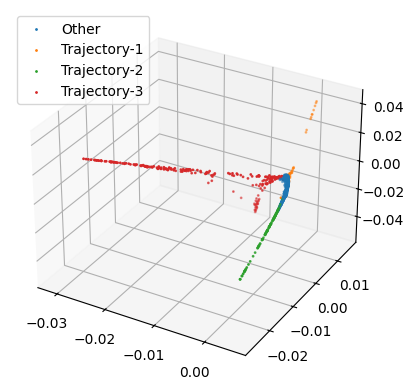

In [10]:
gene_trajectory = extract_gene_trajectory(gene_embedding, gene_dist_mat, gene_names=genes,
                                          t_list = [5, 5, 7], dims=10)
plot_gene_trajectory_3d(gene_trajectory)

To examine how each given gene trajectory is reflected over the cell graph, we can track how these genes are expressed across different regions in the cell embedding. Here, we have applied ALRA imputation to smooth the expression values for generating gene bin plots and the result is available in the `alra` layer.



In [11]:
add_gene_bin_score(adata, gene_trajectory=gene_trajectory, n_bins=7, trajectories=3, layer='alra')

After the gene bins are added, the trajectories can be visualized using the `plot_gene_trajectory_umap` function. We also add the `cell_type` panel to show that Trajectory 1 ends in DC cells. 

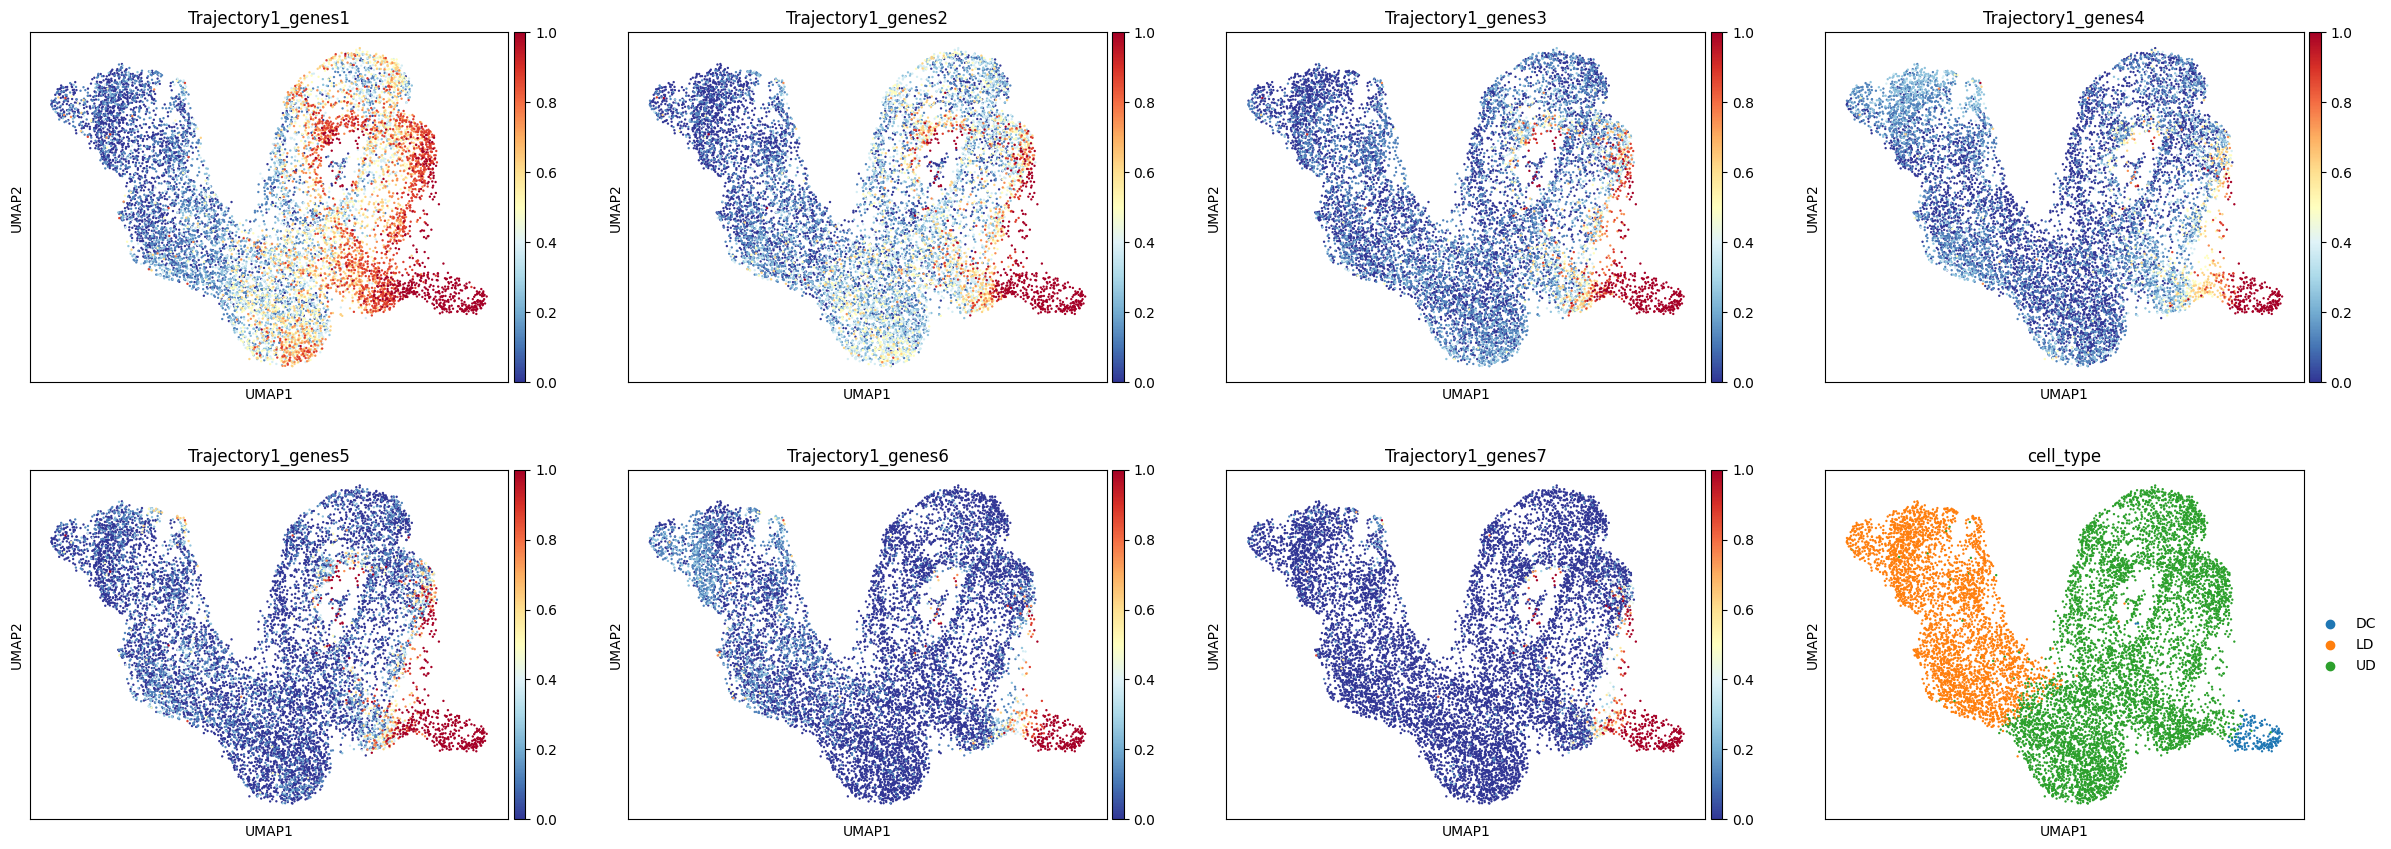

In [12]:
plot_gene_trajectory_umap(adata, 'Trajectory1', other_panels='cell_type')

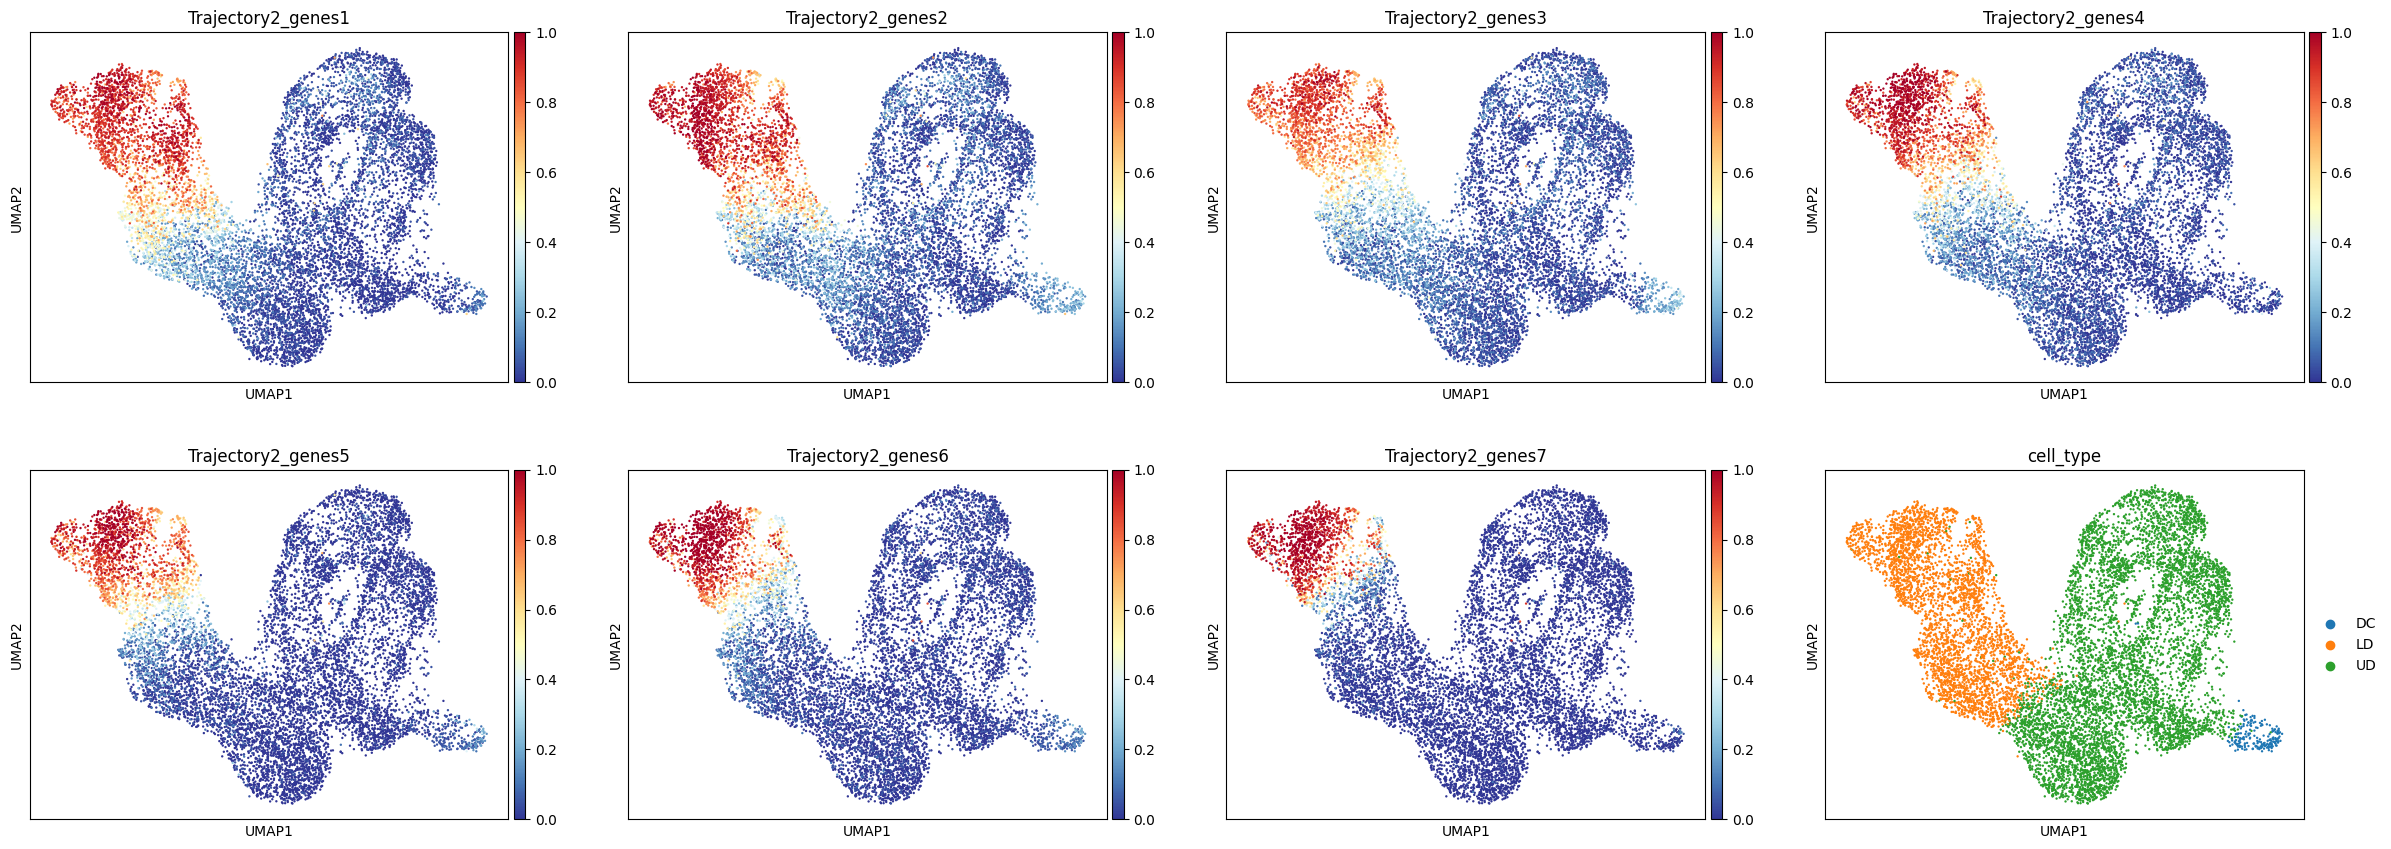

In [13]:
plot_gene_trajectory_umap(adata, 'Trajectory2', other_panels='cell_type')

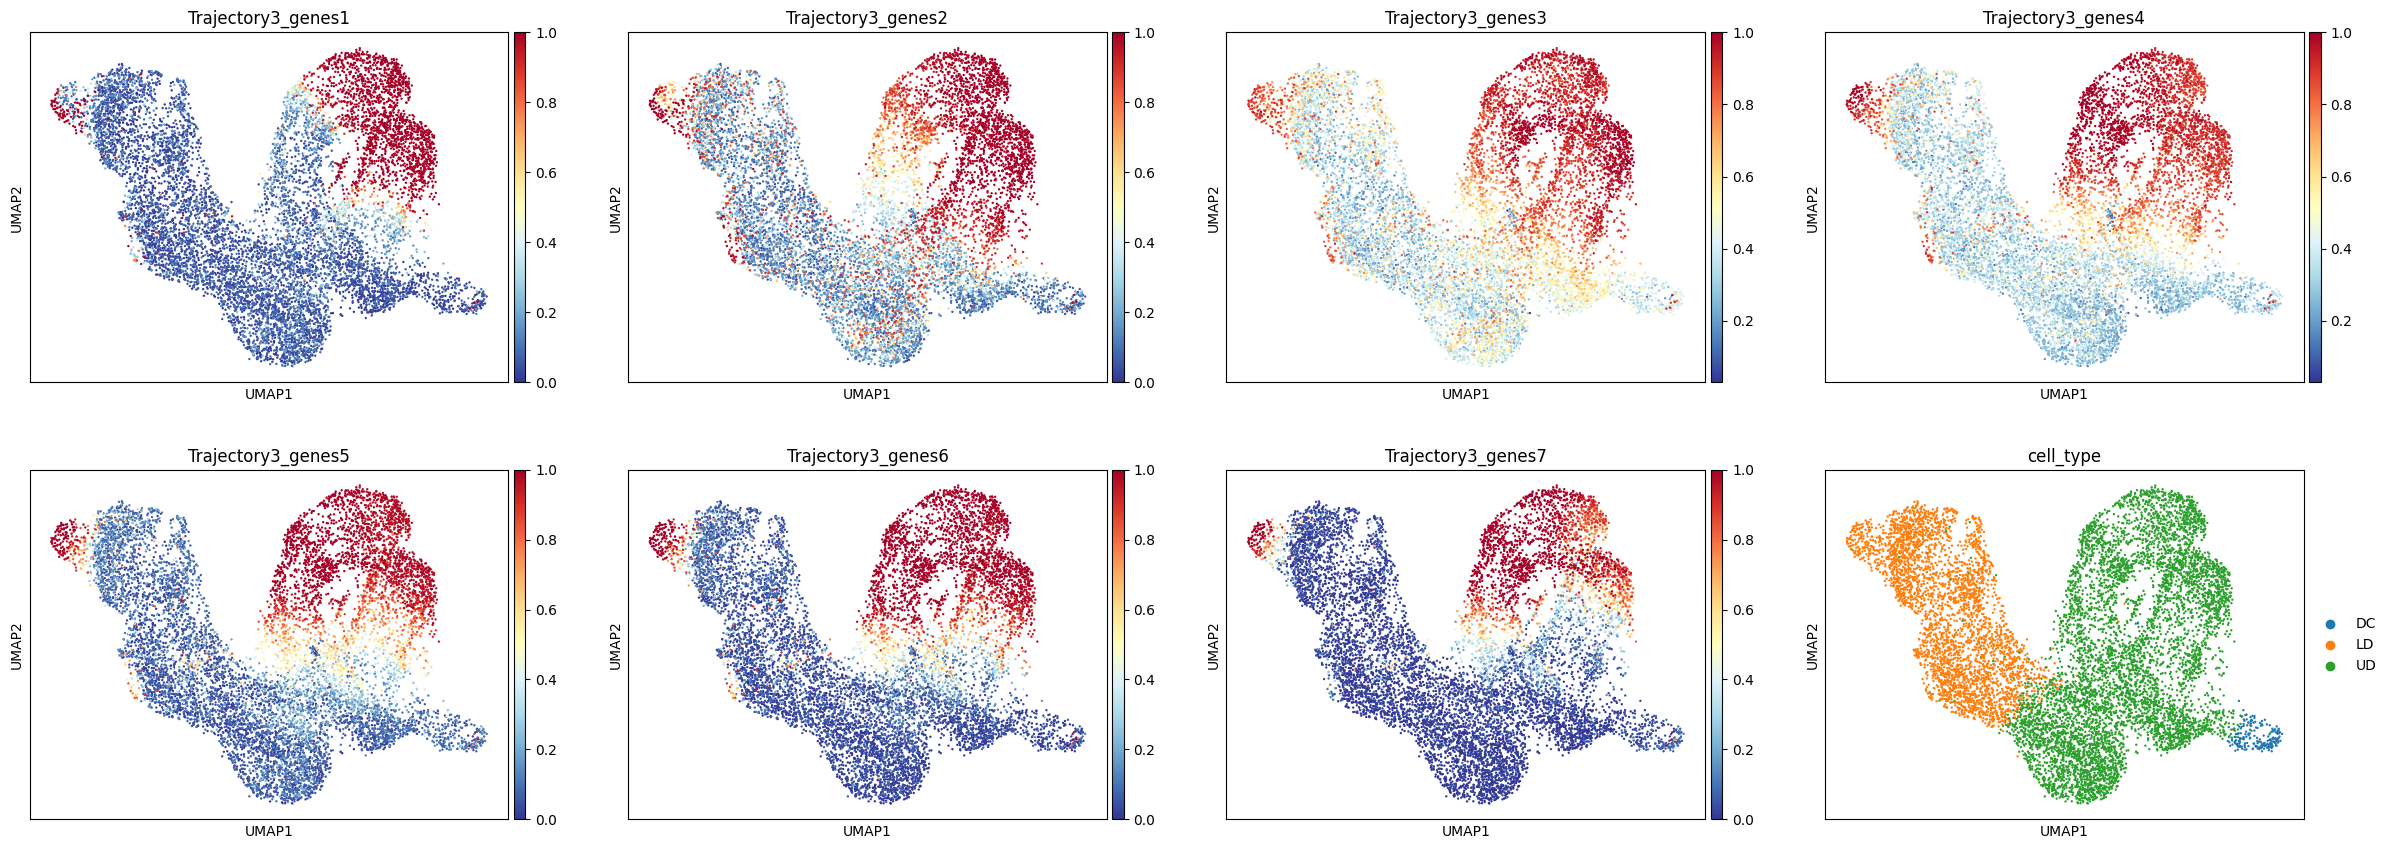

In [14]:
plot_gene_trajectory_umap(adata, 'Trajectory3', other_panels='cell_type')